# Basic implementation
This notebook shows the basic implementation of the streaming algorithm for SVDs with a simple test dataset. We will show the implementation is correct with reference to the exact SVD.

## Setup

First, import all the clobber and set up the plot parameters.



In [1]:
using LinearAlgebra
using GLMakie
GLMakie.activate!()
include("../src/StreamSVD.jl")
;


Test Summary: | Pass  Total  Time
Test the SVDs |    8      8  0.5s


In [2]:

fig = Figure(resolution = (700, 500))
ax = Axis3(
    fig[1,1],
    xlabel="X",
    ylabel="T",
    zlabel="Y",
    )

Axis3()

## Test function
We use a time varying hyperbolic secant function to generate a time series of matrices. The function is defined as follows:

$$
\begin{align*}
    f_1 &= \text{sech}(X - 3.5) \cdot 10.0 \cdot \cos(0.5 \cdot t) \\
    f_2 &= \cos(X) \cdot 1.0 \cdot \cos(2.5 \cdot t) \\
    f_3 &= \text{sech}(X + 5.0) \cdot 4.0 \cdot \cos(1.0 \cdot t) \\
    U &= f_1 + f_2 + f_3
\end{align*}
$$

In [3]:

m = 120; n = 50; k = 5
t, x = range(0, stop=30, length=n), range(-10, stop=30, length=m)

Xgrid = [i for i in x, j in t]
tgrid = [j for i in x, j in t]

f1 = sech.(Xgrid.-3.5) .* 10.0 .* cos.(0.5 .*tgrid)
f2 = cos.(Xgrid) .* 1.0 .* cos.(2.5 .*tgrid)
f3 = sech.(Xgrid.+5.0) .* 4.0 .* cos.(1.0 .*tgrid)

Y = f1+f2+f3;

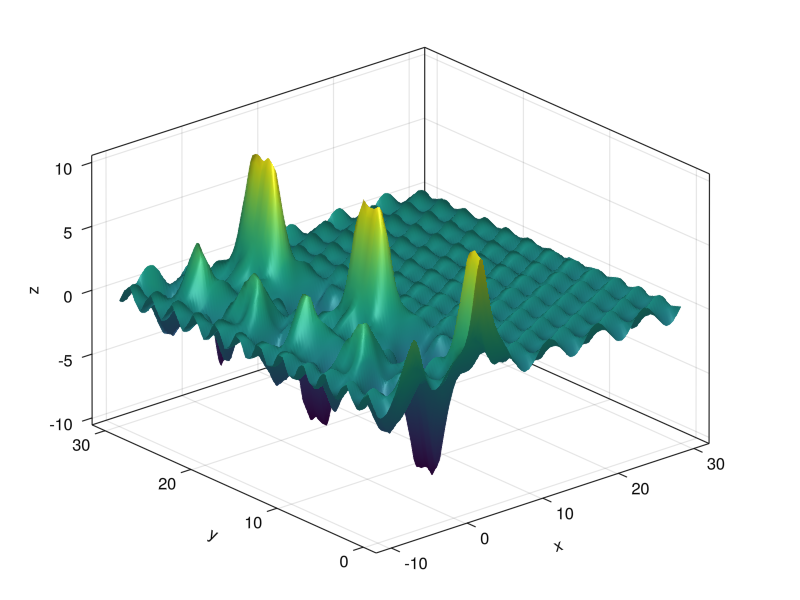

In [21]:

surface(Xgrid, tgrid, Y, axis=(type=Axis3,))

## Simple POD
Now we take the exact POD of the data. We will use this to compare the results of the streaming algorithm to the exact solution.

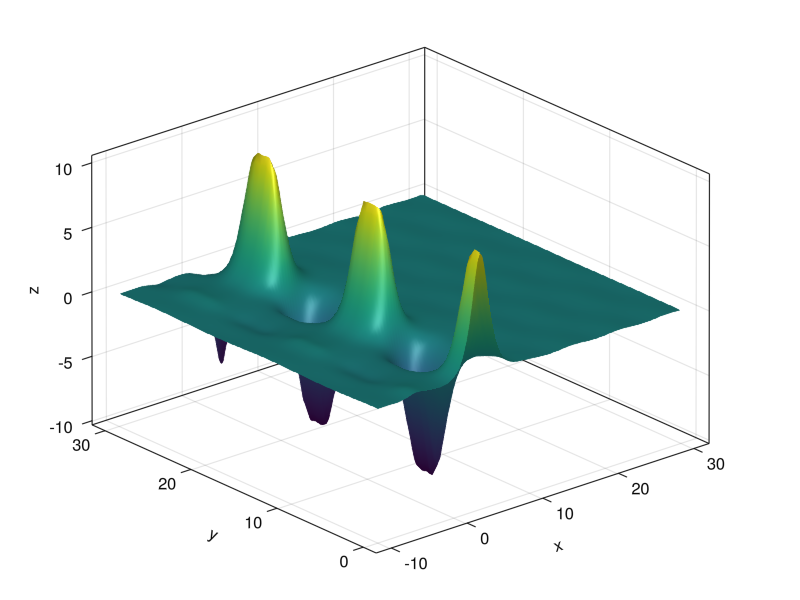

In [28]:
U, Σ, V = svd(Y)
A = Diagonal(Σ)*V'
M1 = U[:,1:1] * A[1:1, :]
surface(Xgrid, tgrid, M1, axis=(type=Axis3,))

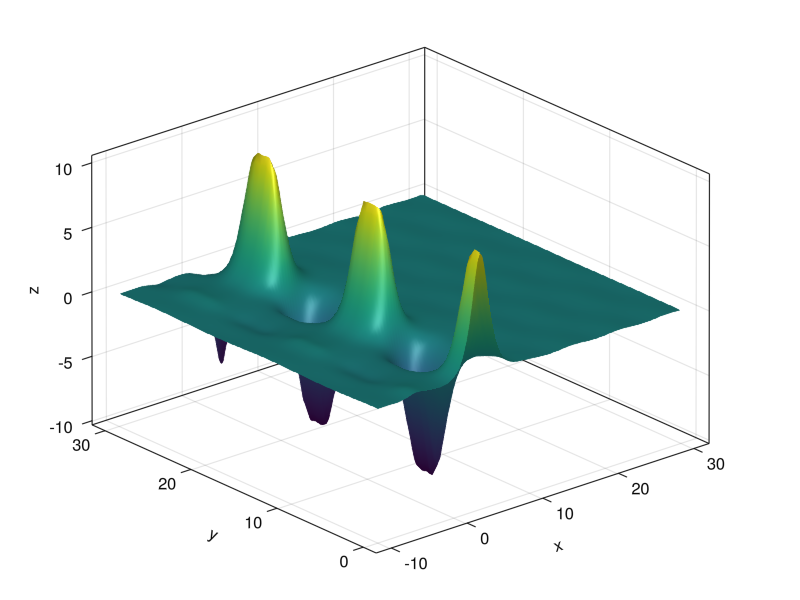

In [29]:

U, Σ, V = svd(Y)
Ut = U[:, 1:k]
Σt = Σ[1:k]
Vt = V[:, 1:k]
A = Diagonal(Σt)*Vt'
M1 = Ut[:,1:1] * A[1:1, :]
surface(Xgrid, tgrid, M1, axis=(type=Axis3,))


## POD using the QR decomposition

Using the QR decomposition in the context of POD offers advantages such as providing an orthogonal basis, enabling rank reduction, ensuring numerical stability, offering computational efficiency, and facilitating interpretability. These benefits make it a valuable tool for dimensionality reduction.

In [30]:
function qrSVD(Y,k)
    Q,R = qr(Y)
    B=transpose(Matrix(Q))*Y
    Û,Σ,Vt=svd(B)
    Uk=Û[:, 1:k]
    Vk=Vt'[1:k, :]
    U=Matrix(Q)*Uk
    M = U * diagm(Σ[1:k]) * Vk
    return M, Σ
end
M1, S = qrSVD(Y, 1)
size(M1)

(120, 50)

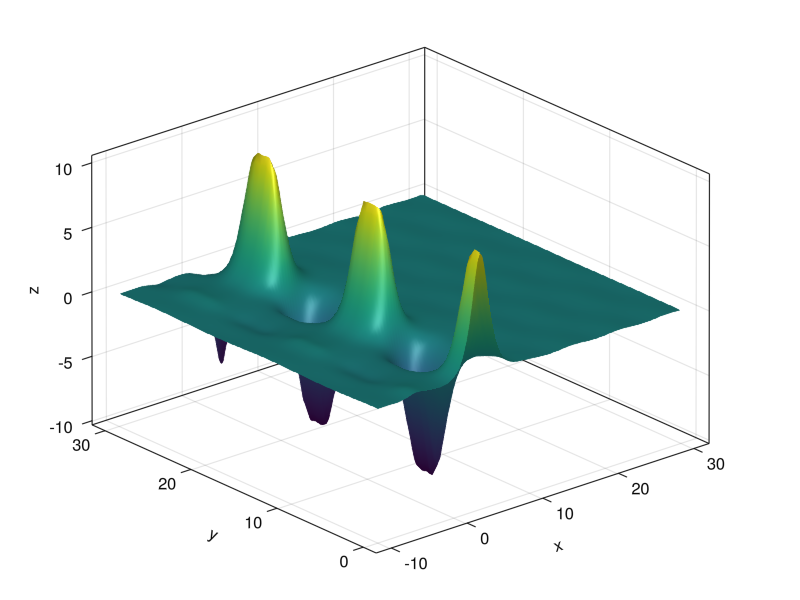

In [27]:
surface(Xgrid, tgrid, M, axis=(type=Axis3,))

## Randomised algorithm
This uses randomised linear algebra, specifically matrix sketching to approximate the SVD.

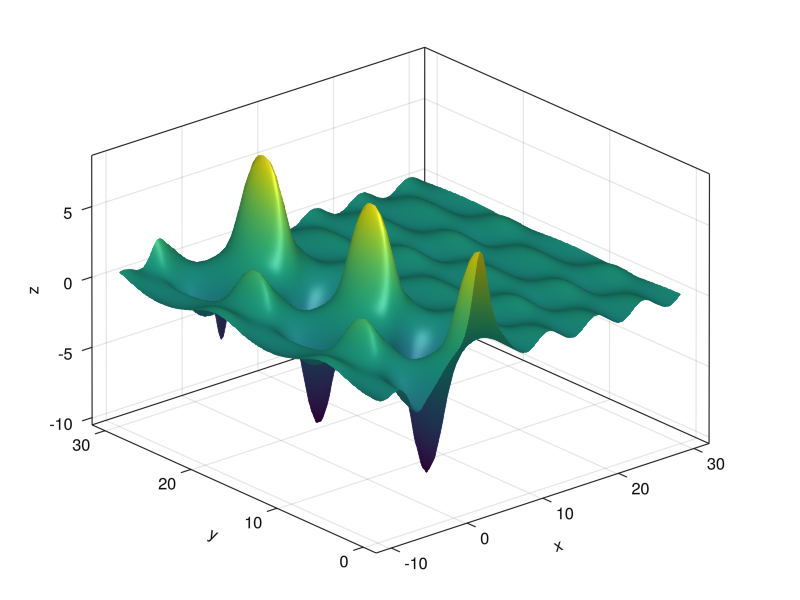

In [25]:
function rSVD(A,k)
    (m,n)=size(A)
    Phi=rand(n,k)
    Y=A*Phi
    Q,R = qr(Y)
    B=transpose(Matrix(Q))*A
    Û,Σ,Vt=svd(B)
    Uk=Û[:, 1:k]
    Vk=Vt'[1:k, :]
    U=Matrix(Q)*Uk
    M = U * diagm(Σ[1:k]) * Vk
    return M, Σ
end
M, S = rSVD(Y, 1)
surface(Xgrid, tgrid, M, axis=(type=Axis3,))

## Finally, we look at the streaming algorithm

First, we'll split the data up into chunks.

In [31]:
Y1 = Y[:, 1:25]
Y2 = Y[:, 26:50]

120×25 Matrix{Float64}:
 -0.757735   0.368572    0.705303  …   0.749762   0.270226   -0.765122
 -0.889358   0.414031    0.807804      0.856722   0.307139   -0.883925
 -0.937119   0.396485    0.808296      0.852846   0.302146   -0.901172
 -0.901927   0.31125     0.702097      0.732606   0.252802   -0.813886
 -0.796457   0.158581    0.494634      0.501132   0.160436   -0.630377
 -0.644692  -0.0573775   0.200122  …   0.172725   0.0295374  -0.369147
 -0.480533  -0.330428   -0.160981     -0.231979  -0.133363   -0.056607
 -0.345666  -0.654787   -0.5655       -0.689905  -0.321228    0.276158
 -0.286853  -1.0278     -0.991573     -1.17998   -0.528234    0.597198
 -0.352424  -1.45209    -1.42238      -1.68715   -0.751261    0.877558
  ⋮                                ⋱                         
 -0.481661   0.286553    0.504685      0.542135   0.200004   -0.526065
 -0.683286   0.406505    0.715947      0.769074   0.283726   -0.746277
 -0.808433   0.480958    0.847076      0.909933   0.335691   -

In [45]:
function initialize(A, k)
    # q, r = qr(A)
    # ui, Σ, vit = svd(r)
    # M = q * ui[:, 1:k]
    # Σ = Σ[1:k]

    Q,R = qr(A)
    B=transpose(Matrix(Q))*A
    Û,Σ,Vt=svd(B)
    Uk=Û[:, 1:k]
    Vk=Vt'[1:k, :]
    U=Matrix(Q)*Uk
    M = U * diagm(Σ[1:k]) * Vk
    return M, Σ
end

function incorporate_data(A, M, Σ, k)
    m_ap = M #* Diagonal(Σ)
    m_ap = hcat(m_ap, A)
    println(size(m_ap))
    Qi, Ri = qr(m_ap)
    Bi=transpose(Matrix(Qi))*A
    ũi, d̃i, ṽti = svd(Bi)
    max_idx = sortperm(d̃i, rev=true)[1:k]
    Σ = d̃i[max_idx]
    ũi = ũi[:, max_idx]
    ṽi=ṽti'[1:k, :]
    M = Qi * ũi
    M = M * diagm(Σ[1:k]) * ṽi
    return M, Σ
end

incorporate_data (generic function with 1 method)

(120, 50)
(120, 25)


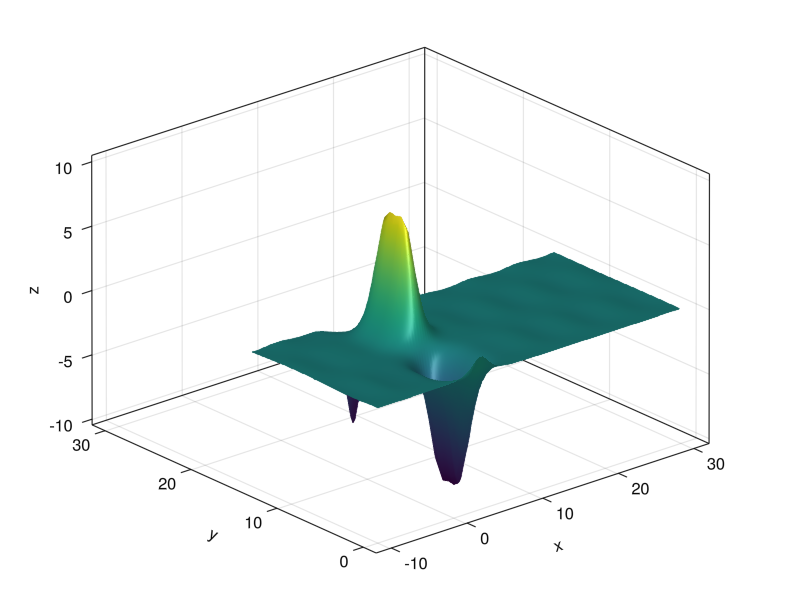

In [47]:
M, Σ = initialize(Y1, 1)
M, Σ = incorporate_data(Y2, M, Σ, 1)
println(size(M))
surface(Xgrid, tgrid, M, axis=(type=Axis3,))